In [8]:
!pip install sqlparse transformers torch scikit-learn tqdm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [9]:
import os
import random
import sqlparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
from tqdm import tqdm


2025-12-15 23:24:23.923882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765841064.097698      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765841064.146504      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [11]:
TPCH_TABLES_PATH = "/kaggle/input/tpc-h-dataset"
TPCH_QUERIES_PATH = "/kaggle/input/tpch-queries"

In [12]:
def load_tpch_queries(path):
    queries = []
    for file in sorted(os.listdir(path)):
        if file.endswith(".sql"):
            with open(os.path.join(path, file)) as f:
                queries.append(f.read())
    return queries

raw_queries = load_tpch_queries(TPCH_QUERIES_PATH)
print("Total TPC-H Queries:", len(raw_queries))


Total TPC-H Queries: 22


In [13]:
def canonicalize_sql(query):
    return sqlparse.format(
        query,
        keyword_case='lower',
        identifier_case='lower',
        strip_comments=True,
        reindent=False
    )

canonical_queries = [canonicalize_sql(q) for q in raw_queries]


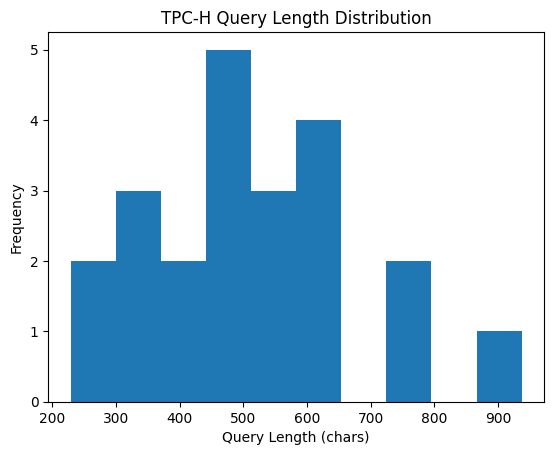

In [14]:
query_lengths = [len(q) for q in canonical_queries]

plt.figure()
plt.hist(query_lengths, bins=10)
plt.xlabel("Query Length (chars)")
plt.ylabel("Frequency")
plt.title("TPC-H Query Length Distribution")
plt.show()

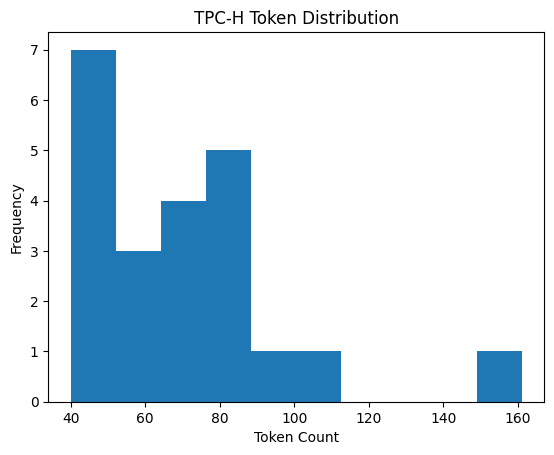

In [15]:
token_counts = [len(q.split()) for q in canonical_queries]

plt.figure()
plt.hist(token_counts, bins=10)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("TPC-H Token Distribution")
plt.show()

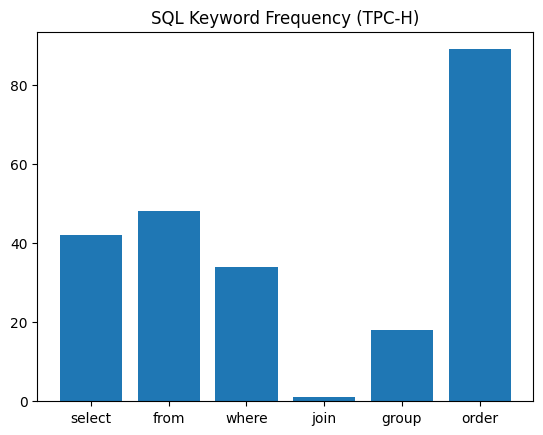

In [16]:
keywords = ["select", "from", "where", "join", "group", "order"]
freq = {k: 0 for k in keywords}

for q in canonical_queries:
    for k in keywords:
        freq[k] += q.count(k)

plt.figure()
plt.bar(freq.keys(), freq.values())
plt.title("SQL Keyword Frequency (TPC-H)")
plt.show()

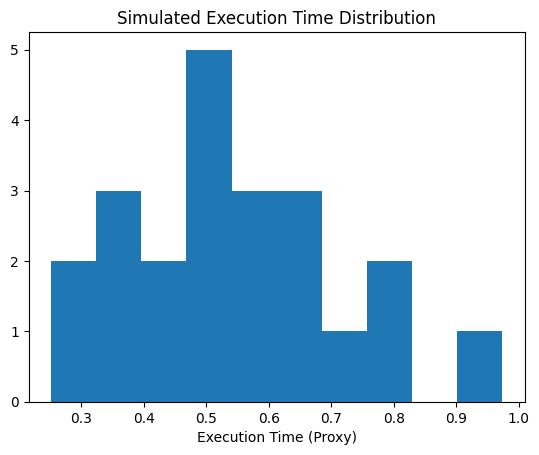

In [17]:
def simulate_execution_time(query):
    return len(query) / 1000 + random.uniform(0.01, 0.05)

exec_times = [simulate_execution_time(q) for q in canonical_queries]

plt.figure()
plt.hist(exec_times, bins=10)
plt.xlabel("Execution Time (Proxy)")
plt.title("Simulated Execution Time Distribution")
plt.show()

In [18]:
def augment_sql(query):
    tokens = query.split()
    return random.choice([
        query,
        " ".join(tokens),
        " ".join(random.sample(tokens, len(tokens)))
    ])

In [19]:
class SQLSelfSupervisedDataset(Dataset):
    def __init__(self, queries):
        self.queries = queries

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        q = self.queries[idx]
        return augment_sql(q), augment_sql(q), simulate_execution_time(q)

In [20]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

dataset = SQLSelfSupervisedDataset(canonical_queries)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [21]:
class SQLQueryEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

    def forward(self, **inputs):
        outputs = self.bert(**inputs)
        return outputs.last_hidden_state[:, 0, :]


In [22]:
def contrastive_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    logits = torch.matmul(z1, z2.T) / temperature
    labels = torch.arange(z1.size(0)).to(z1.device)
    return F.cross_entropy(logits, labels)

In [23]:
model = SQLQueryEncoder().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [24]:
from sklearn.model_selection import train_test_split

train_queries, val_queries = train_test_split(
    canonical_queries,
    test_size=0.3,
    random_state=42
)

print("Train queries:", len(train_queries))
print("Validation queries:", len(val_queries))


Train queries: 15
Validation queries: 7


In [25]:
train_dataset = SQLSelfSupervisedDataset(train_queries)
val_dataset = SQLSelfSupervisedDataset(val_queries)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [40]:
EPOCHS = 50
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # -------- TRAIN --------
    model.train()
    train_loss = 0

    for q1, q2, exec_time in train_loader:
        enc1 = tokenizer(list(q1), padding=True, truncation=True, return_tensors="pt").to(device)
        enc2 = tokenizer(list(q2), padding=True, truncation=True, return_tensors="pt").to(device)

        enc1.pop("token_type_ids", None)
        enc2.pop("token_type_ids", None)

        z1 = model(**enc1)
        z2 = model(**enc2)

        loss = contrastive_loss(z1, z2)
        exec_time = torch.tensor(exec_time, dtype=torch.float32).to(device)
        weighted_loss = loss * torch.mean(1.0 / exec_time)

        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        train_loss += weighted_loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for q1, q2, exec_time in val_loader:
            enc1 = tokenizer(list(q1), padding=True, truncation=True, return_tensors="pt").to(device)
            enc2 = tokenizer(list(q2), padding=True, truncation=True, return_tensors="pt").to(device)

            enc1.pop("token_type_ids", None)
            enc2.pop("token_type_ids", None)

            z1 = model(**enc1)
            z2 = model(**enc2)

            loss = contrastive_loss(z1, z2)
            exec_time = torch.tensor(exec_time, dtype=torch.float32).to(device)
            val_loss += (loss * torch.mean(1.0 / exec_time)).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


/tmp/ipykernel_47/2446580941.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  exec_time = torch.tensor(exec_time, dtype=torch.float32).to(device)
/tmp/ipykernel_47/2446580941.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  exec_time = torch.tensor(exec_time, dtype=torch.float32).to(device)


Epoch 1 | Train Loss: 1.0845 | Val Loss: 1.0613
Epoch 2 | Train Loss: 0.9262 | Val Loss: 1.0465
Epoch 3 | Train Loss: 0.8673 | Val Loss: 1.2502
Epoch 4 | Train Loss: 0.9808 | Val Loss: 1.4412
Epoch 5 | Train Loss: 0.8418 | Val Loss: 1.0980
Epoch 6 | Train Loss: 0.7701 | Val Loss: 0.8809
Epoch 7 | Train Loss: 0.9180 | Val Loss: 0.9079
Epoch 8 | Train Loss: 0.7866 | Val Loss: 0.9660
Epoch 9 | Train Loss: 1.0239 | Val Loss: 0.9484
Epoch 10 | Train Loss: 0.9944 | Val Loss: 1.0254
Epoch 11 | Train Loss: 0.8610 | Val Loss: 0.9675
Epoch 12 | Train Loss: 0.7682 | Val Loss: 0.9893
Epoch 13 | Train Loss: 0.7970 | Val Loss: 0.8682
Epoch 14 | Train Loss: 0.6878 | Val Loss: 0.8588
Epoch 15 | Train Loss: 0.8931 | Val Loss: 0.8362
Epoch 16 | Train Loss: 0.6978 | Val Loss: 0.9229
Epoch 17 | Train Loss: 0.9062 | Val Loss: 0.9964
Epoch 18 | Train Loss: 0.7481 | Val Loss: 0.9824
Epoch 19 | Train Loss: 0.9089 | Val Loss: 0.9818
Epoch 20 | Train Loss: 0.7271 | Val Loss: 0.9699
Epoch 21 | Train Loss: 0.7249

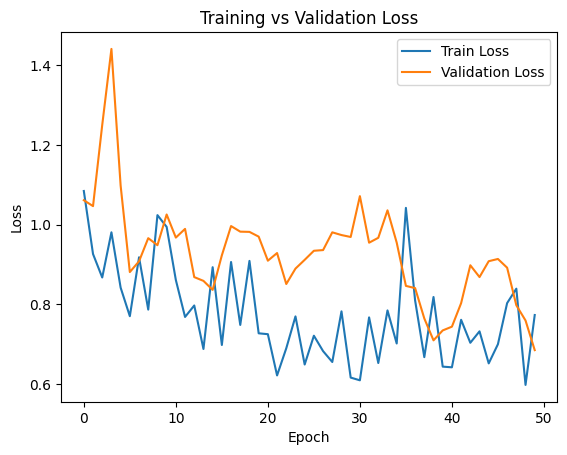

In [41]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


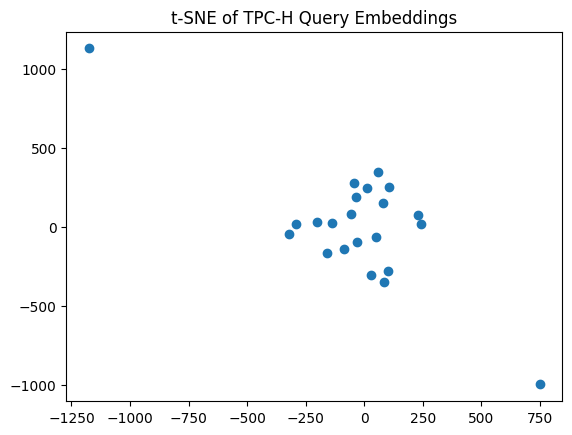

In [42]:
model.eval()

def get_embedding(query):
    enc = tokenizer(query, return_tensors="pt", truncation=True).to(device)
    enc.pop("token_type_ids", None)
    with torch.no_grad():
        emb = model(**enc)
    return emb.cpu().numpy()

embeddings = np.vstack([get_embedding(q) for q in canonical_queries])
tsne = TSNE(n_components=2, perplexity=5)
reduced = tsne.fit_transform(embeddings)

plt.figure()
plt.scatter(reduced[:,0], reduced[:,1])
plt.title("t-SNE of TPC-H Query Embeddings")
plt.show()


In [43]:
MODEL_PATH = "/kaggle/working/sql_energy_self_supervised_model"

model.bert.save_pretrained(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

print("Model saved to:", MODEL_PATH)


Model saved to: /kaggle/working/sql_energy_self_supervised_model


In [44]:
from transformers import BertModel, BertTokenizer

MODEL_PATH = "/kaggle/working/sql_energy_self_supervised_model"

tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
bert = BertModel.from_pretrained(MODEL_PATH).to(device)
bert.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [46]:
def extract_embedding(query):
    enc = tokenizer(
        query,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to(device)

    enc.pop("token_type_ids", None)

    with torch.no_grad():
        outputs = bert(**enc)
        emb = outputs.last_hidden_state[:, 0, :]

    return emb.cpu()


In [47]:
from torch.nn.functional import cosine_similarity

similarities = []

for q in canonical_queries:
    q_aug = augment_sql(q)
    e1 = extract_embedding(q)
    e2 = extract_embedding(q_aug)
    sim = cosine_similarity(e1, e2).item()
    similarities.append(sim)

print("Average Cosine Similarity:", sum(similarities)/len(similarities))


Average Cosine Similarity: 0.9961534413424405


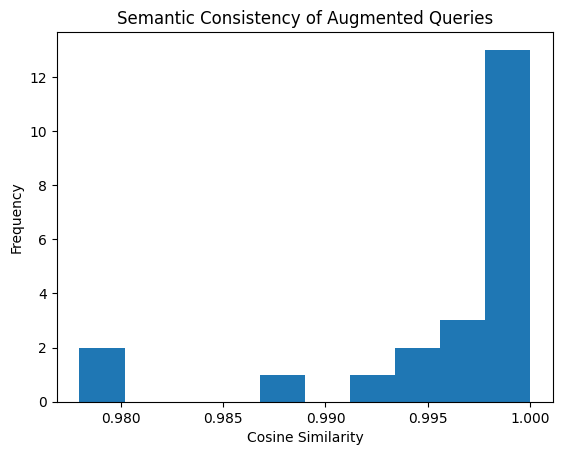

In [48]:
plt.figure()
plt.hist(similarities, bins=10)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Semantic Consistency of Augmented Queries")
plt.show()


In [49]:
from sklearn.metrics.pairwise import cosine_distances

embeddings = []
times = []

for q in canonical_queries:
    embeddings.append(extract_embedding(q).numpy()[0])
    times.append(simulate_execution_time(q))

embeddings = np.array(embeddings)
times = np.array(times)

distance_matrix = cosine_distances(embeddings)
avg_distance = distance_matrix.mean(axis=1)


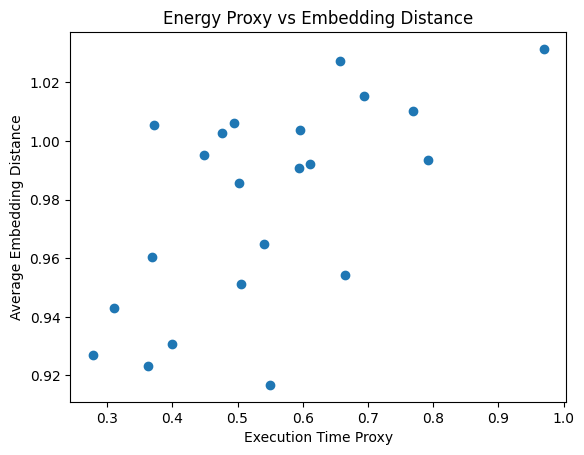

In [50]:
plt.figure()
plt.scatter(times, avg_distance)
plt.xlabel("Execution Time Proxy")
plt.ylabel("Average Embedding Distance")
plt.title("Energy Proxy vs Embedding Distance")
plt.show()


In [51]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(embeddings)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


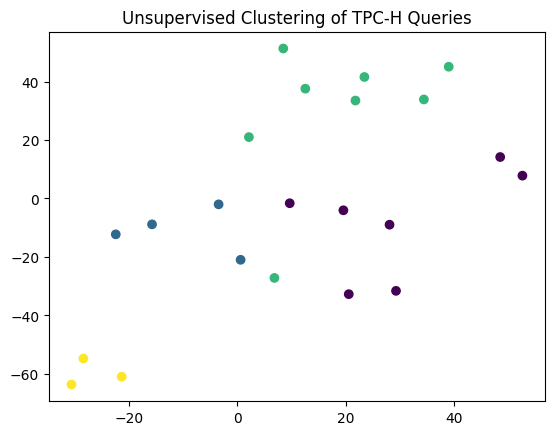

In [52]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced = tsne.fit_transform(embeddings)

plt.figure()
plt.scatter(reduced[:,0], reduced[:,1], c=clusters)
plt.title("Unsupervised Clustering of TPC-H Queries")
plt.show()


In [53]:
baseline_bert = BertModel.from_pretrained("bert-base-uncased").to(device)
baseline_bert.eval()

def baseline_embedding(query):
    enc = tokenizer(query, return_tensors="pt", truncation=True).to(device)
    enc.pop("token_type_ids", None)
    with torch.no_grad():
        return baseline_bert(**enc).last_hidden_state[:,0,:].cpu()

baseline_sims = []

for q in canonical_queries:
    q_aug = augment_sql(q)
    e1 = baseline_embedding(q)
    e2 = baseline_embedding(q_aug)
    baseline_sims.append(cosine_similarity(e1, e2).item())


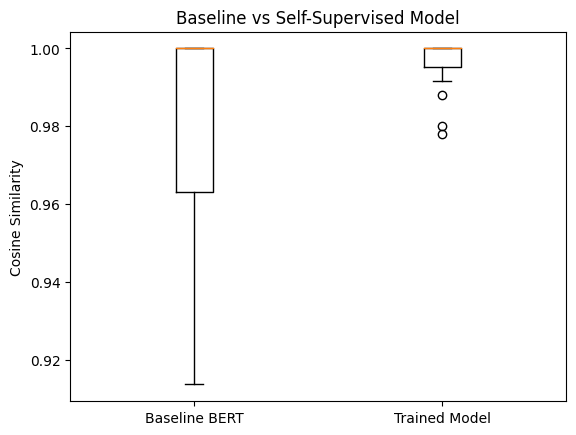

In [54]:
plt.figure()
plt.boxplot([baseline_sims, similarities], labels=["Baseline BERT", "Trained Model"])
plt.ylabel("Cosine Similarity")
plt.title("Baseline vs Self-Supervised Model")
plt.show()
